# Compare cell lines 

Aim: Looking for genes that are hyper methylated and sensitized in HL60 cell line, and show decrease in RNA expression or stability among multiple AML cell lines. 

In [1]:
import sys 
import pandas as pd 
import numpy as np
from matplotlib.pyplot import subplots
from itertools import chain, product
from matplotlib_venn import venn3,venn3_circles, venn3_unweighted
from venn import venn 

import upsetplot as us
from matplotlib.backends.backend_pdf import PdfPages

sys.path.append('../')

from util import *

In [2]:
wd = '/data_gilbert/home/aarab/Projects/Decitabine-treatment/'

In [22]:
!mkdir -p cell-line-consistency

## Load data
Comparing treated with Decitabine vs. non-treated:
- **$\Delta$RNA methylation**  (hl60 cell line)
- **$\Delta$Translational efficiency** (hl60 cell line)
- **$\Delta$RNA expression** (For all 6 AML cell lines)
- **$\Delta$RNA stability** (For all 6 AML cell lines)
- **$\Delta$Phenotype, CRISPRi-screen $\rho$(rho) score** (hl60 and molm13 cell lines) 

https://stackoverflow.com/questions/8376335/styling-part-of-label-in-legend-in-matplotlib

In [3]:
def upset_to_intersect(upset_data, extract):
    ids = us.from_contents(upset_data).id.to_list()
    df = us.from_contents(upset_data).index.to_frame().reset_index(drop=True)
    df.index = ids
    out = df[df[extract].sum(axis=1) == len(extract)].index.to_list()
    return out

In [4]:
comps = load_data(comparisons=True,wd=wd)

## rho down

In [5]:
scrns = load_data(screens=True,wd=wd)

scrns['hl60_exp1_DAC_rho'] = scrns['hl60_exp1_DAC_rho'].astype(float)

scrns['hl60_exp1_DAC_rho'].columns

_,Ci_down = find_top(
    scrns['hl60_exp1_DAC_rho'],'rho score', 0.1,'Mann-Whitney p-value',0.05
)

up:  592
down: 701


## hyper methylation

In [6]:
mtyl_up, _ = find_top(comps['delta_mtyl'],"logFC",1,"pval",0.05)

up:  2064
down: 1399


# Exp

In [45]:
cell_lines = {}

for fc, pval in zip(comps['delta_exp'].columns[1::2],  comps['delta_exp'].columns[2::2]):
    
    print (fc.replace('_log2FC',''))
    _,exp_down = find_top(comps['delta_exp'].dropna(),fc, 0.1, pval, 0.05,silent=True)
    print (20*'_')
    
    cell_lines[fc.replace('_log2FC','')] = list(set(
        exp_down.gene_name.tolist()).intersection(set(
        Ci_down.index.tolist())).intersection(set(
        mtyl_up.gene_name)))
    print(len(cell_lines[fc.replace('_log2FC','')]))

del cell_lines['hl60_72h_only']
del cell_lines['hl60_6h']

hl60_6h
____________________
9
hl60_72h
____________________
10
hl60_72h_only
____________________
4
hl60_120h
____________________
16
kg1
____________________
4
molm14
____________________
7
ociaml2
____________________
1
ociaml3
____________________
3
thp1
____________________
2


In [46]:
upset_data = dict([(c,cell_lines[c]) for c in cell_lines if cell_lines[c]])

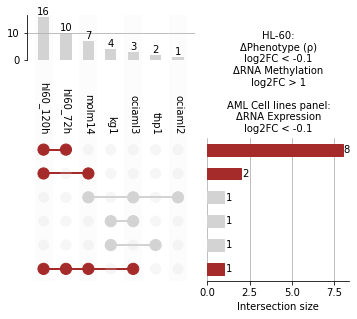

In [47]:
# Expression upset plot
fig1 = plt.figure()
upset1 = us.UpSet(
    us.from_contents(upset_data),
    min_degree=2,
    sort_by='cardinality',
    orientation='vertical',
    show_counts=True,
    # totals_plot_elements=10,
    other_dots_color=0.2,
    facecolor='lightgrey'
)
upset1.style_subsets(
    present=["hl60_72h"], 
    # label="", 
    facecolor='brown'
)
upset1.style_subsets(
    present=["hl60_120h"], 
    facecolor='brown'
)

upset1.plot(fig=fig1)
plt.title(
    "HL-60:\nΔPhenotype (ρ)\nlog2FC < -0.1\nΔRNA Methylation\nlog2FC > 1\n\nAML Cell lines panel:\nΔRNA Expression\nlog2FC < -0.1",
    fontsize=10,#fontweight='bold'
)
plt.savefig('cell-line-consistency/intersection_exp_upset_plot.pdf',dpi=300)
plt.show()

In [48]:
upset_to_intersect(upset_data, extract = ['hl60_120h','molm14'])

['MYBBP1A', 'XRCC2', 'SMC4']

In [49]:
upset_to_intersect(upset_data, extract = ['hl60_72h','hl60_120h','molm14','ociaml3'])

['MYBBP1A']

> #### Role and potential for therapeutic targeting of MYB in leukemia
> - https://www.nature.com/articles/leu2012225
> - The NRD is believed to act at least in part by the recruitment of co-repressors, such as TIF1β and __Mybbp1a__, that interfere with target gene activation.

In [19]:
upset_to_intersect(upset_data, extract = ['hl60_72h','hl60_120h'])

['DHODH',
 'MYBBP1A',
 'PMPCA',
 'SLC7A6',
 'ZNF777',
 'INTS5',
 'SQLE',
 'RNF126',
 'RBM14-RBM4']

## Stbl

In [28]:
cell_lines = {}

for fc, pval in zip(comps['delta_stbl'].columns[1::2],  comps['delta_stbl'].columns[2::2]):
    
    print (fc.replace('_log2FC',''))
    _,exp_down = find_top(comps['delta_stbl'].dropna(),fc, 0.1, pval, 0.05,silent=True)
    print (20*'_')
    
    cell_lines[fc.replace('_log2FC','')] = list(set(
        exp_down.gene_name.tolist()).intersection(set(
        Ci_down.index.tolist())).intersection(set(
        mtyl_up.gene_name)))
    print(len(cell_lines[fc.replace('_log2FC','')]))

del cell_lines['hl60_6h']

hl60_120h
____________________
6
hl60_72h
____________________
1
hl60_6h
____________________
2
kg1
____________________
1
molm14
____________________
3
ociaml2
____________________
1
ociaml3
____________________
4
thp1
____________________
3


In [29]:
upset_data = dict([(c,cell_lines[c]) for c in cell_lines if cell_lines[c]])

In [30]:
upset_data.keys()

dict_keys(['hl60_120h', 'hl60_72h', 'kg1', 'molm14', 'ociaml2', 'ociaml3', 'thp1'])

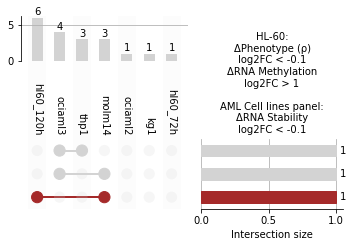

In [43]:
# Stability upset plot
fig1 = plt.figure()
upset1 = us.UpSet(
    us.from_contents(upset_data),
    min_degree=2,
    sort_by='cardinality',
    orientation='vertical',
    show_counts=True,
    # totals_plot_elements=10,
    other_dots_color=0.2,
    facecolor='lightgrey'
)
upset1.style_subsets(
    present=["hl60_72h"], 
    # label="", 
    facecolor='brown'
)
upset1.style_subsets(
    present=["hl60_120h"], 
    facecolor='brown'
)

upset1.plot(fig1)


plt.title(
    "HL-60:\nΔPhenotype (ρ)\nlog2FC < -0.1\nΔRNA Methylation\nlog2FC > 1\n\nAML Cell lines panel:\nΔRNA Stability\nlog2FC < -0.1",
    fontsize=10,#fontweight='bold'
)
plt.savefig('cell-line-consistency/intersection_stbl_upset_plot.pdf',dpi=300)
plt.show()

In [108]:
upset_to_intersect(upset_data, extract = ['molm14','hl60_120h'])

['BCL2']

In [109]:
upset_to_intersect(upset_data, extract = ['molm14','ociaml3'])

['PTTG1IP']

In [110]:
upset_to_intersect(upset_data, extract = ['thp1','ociaml3'])

['MARK3']

In [76]:
!date

Sun Feb 13 23:22:10 PST 2022
